Note: We are using code for Victim Model & FGSM attack 

Team
1. Lakshmi Nadh Makkena
2. Sravani Potteti
3. Akhil Jonnalagadda

#### Create Victim Model

c:\Users\laksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7601 - loss: 0.8383 - val_accuracy: 0.9203 - val_loss: 0.2745
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9343 - loss: 0.2107 - val_accuracy: 0.9374 - val_loss: 0.2036
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9583 - loss: 0.1335 - val_accuracy: 0.9409 - val_loss: 0.2022
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9727 - loss: 0.0934 - val_accuracy: 0.9470 - val_loss: 0.1782
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9771 - loss: 0.0745 - val_accuracy: 0.9453 - val_loss: 0.1820
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9856 - loss: 0.0499 - val_accuracy: 0.9505 - val_loss: 0.1780
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9927 - loss: 0.0291 - val_accuracy: 0.9477 - val_loss: 0.1905
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9919 - loss: 0.0268 - val_accuracy: 0

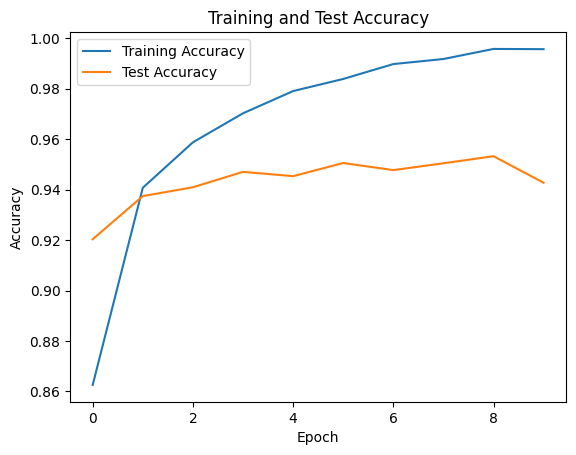

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


nuber_samples = 10000

def create_victim_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

train_images = train_images[:nuber_samples]
train_labels = train_labels[:nuber_samples]
test_images = test_images[:nuber_samples]
test_labels = test_labels[:nuber_samples]

model = create_victim_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Training accuracy:', history.history['accuracy'][-1])
print('Test accuracy:', test_acc)

# Plot training and test accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

# Save the model
model.save('victim_model.h5')


#### FGSM Attack

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Success rate of the FGSM attack: 0.8707
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9364 - loss: 0.2594
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0971 - loss: 9.3751
Test images accuracy: 0.9427000284194946 and Test images loss: 0.23302564024925232
Adversarial images accuracy: 0.12929999828338623 Adversarial images loss: 8.782803535461426


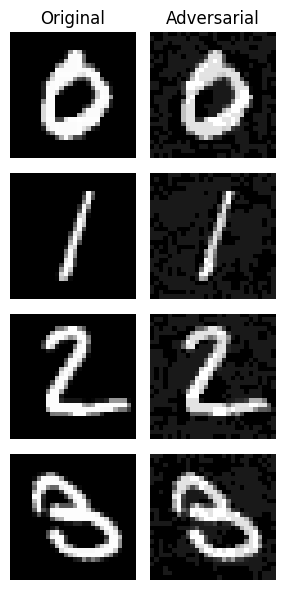

In [9]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models
import matplotlib.pyplot as plt

victim_model = models.load_model('victim_model.h5')

def generate_adversarial_examples(images, labels, epsilon=0.1):
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.int64)
    
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = victim_model(images)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    
    # Get the gradients of the loss with respect to the input images
    gradients = tape.gradient(loss, images)
    
    # Get the sign of the gradients
    signed_grad = tf.sign(gradients)
    
    # Create adversarial examples
    adversarial_examples = images + epsilon * signed_grad
    adversarial_examples = tf.clip_by_value(adversarial_examples, 0, 1)  # Clip to valid image range
    
    return adversarial_examples.numpy()


def evaluate_attack(model, adversarial_examples, original_labels):
    # Predict labels for adversarial examples using victim model
    predicted_labels = np.argmax(model.predict(adversarial_examples), axis=1)
    
    # Calculate success rate
    success_rate = np.mean(predicted_labels != original_labels)
    return success_rate

# Generate adversarial examples using FGSM
epsilon = 0.1  # Adjust epsilon as needed
adversarial_examples = generate_adversarial_examples(test_images, test_labels, epsilon)

# Evaluate the success rate of the attack
success_rate = evaluate_attack(victim_model, adversarial_examples, test_labels)
print("Success rate of the FGSM attack:", success_rate)

# differnce between accuracy of test images and adversarial images
test_loss , test_acc = victim_model.evaluate(test_images, test_labels)
adv_loss , adv_acc = victim_model.evaluate(adversarial_examples, test_labels)

print(f'Test images accuracy: {test_acc} and Test images loss: {test_loss}')
print(f'Adversarial images accuracy: {adv_acc} Adversarial images loss: {adv_loss}')


num_of_images = 4
# Plot the original images and the corresponding adversarial examples
plt.figure(figsize=(3, 6)) 
plt.subplot(num_of_images, 2, 1)
plt.title(f'Original')
plt.axis('off')

plt.subplot(num_of_images, 2, 2)
plt.title('Adversarial')
plt.axis('off')
labels_list = list(test_labels)
for i in range(num_of_images):
    plt.subplot(num_of_images, 2, 2*i + 1)
    plt.imshow(test_images[labels_list.index(i)], cmap='gray')
    plt.axis('off')

    plt.subplot(num_of_images, 2, 2*i + 2)
    plt.imshow(adversarial_examples[labels_list.index(i)], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

#### 1. Input Preprocessing defensive mechanism

In [3]:
# Function to preprocess input data
def input_preprocessing(images):
    # Feature scaling
    images_scaled = images / 255.0
    # Input normalization
    images_normalized = (images_scaled - np.mean(images_scaled)) / np.std(images_scaled)
    # Clip input values
    images_clipped = np.clip(images_normalized, 0, 1)
    return images_clipped

# Function to evaluate the model on test data
def evaluate_model(model, test_images, test_labels):
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    return test_acc


# 1. Input Preprocessing defensive mechanism
preprocessed_train_images = input_preprocessing(train_images)


preprocess_model = create_victim_model()
preprocess_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
preprocess_model.fit(preprocessed_train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Evaluate models after applying input preprocess defensive mechanism
test_acc_after_preprocessing = evaluate_model(preprocess_model, test_images, test_labels)

print("Test accuracy after input preprocessing:", test_acc_after_preprocessing)

# Generate adversarial examples using FGSM after applying defensive mechanism
adversarial_examples_preprocessed = generate_adversarial_examples(test_images, test_labels)

# Evaluate models after applying input preprocess  defensive mechanism
test_acc_after_attack_on_preprocessing = evaluate_model(preprocess_model, adversarial_examples_preprocessed, test_labels)
print("Test accuracy after attack on input preprocessed images:", test_acc_after_attack_on_preprocessing)

# Evaluate the success rate of the attack after applying input preprocess defensive mechanism
success_rate_after_preprocessing = evaluate_attack(preprocess_model, adversarial_examples_preprocessed, test_labels)

print("Success rate of the FGSM attack:", success_rate)
print("Success rate of the FGSM attack after preprocessing:", success_rate_after_preprocessing)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7536 - loss: 0.8506 - val_accuracy: 0.9124 - val_loss: 0.2959
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9380 - loss: 0.2103 - val_accuracy: 0.9363 - val_loss: 0.2110
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9567 - loss: 0.1330 - val_accuracy: 0.9397 - val_loss: 0.1928
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9753 - loss: 0.0837 - val_accuracy: 0.9443 - val_loss: 0.1848
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9833 - loss: 0.0579 - val_accuracy: 0.9507 - val_loss: 0.1542
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9858 - loss: 0.0457 - val_accuracy: 0.9509 - val_loss: 0.1660
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9903 - loss: 0.0302 - val_accuracy: 0.9490 - val_loss: 0.1873
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9970 - loss: 0.0161 - val_accuracy: 0

#### 2. Adversarial Training defensive mechanism

In [4]:
# Function to implement adversarial training
def adversarial_training(model, train_images, train_labels, epsilon=0.1, epochs=10):
    for epoch in range(epochs):
        adversarial_examples = generate_adversarial_examples(train_images, train_labels, epsilon)
        augmented_images = np.concatenate([train_images, adversarial_examples])
        augmented_labels = np.concatenate([train_labels, train_labels])
        model.fit(augmented_images, augmented_labels, epochs=1, verbose=0)
    return model

# 2. Adversarial Training
victim_model_with_adv_training = create_victim_model()
victim_model_with_adv_training.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
victim_model_adv_trained = adversarial_training(victim_model_with_adv_training, train_images, train_labels)

test_acc_after_adversarial_training = evaluate_model(victim_model_adv_trained, test_images, test_labels)

print("Test accuracy after adversarial training:", test_acc_after_adversarial_training)

# Generate adversarial examples using FGSM after applying Adversarial Training defensive mechanism
adversarial_examples_for_adv_training = generate_adversarial_examples(test_images, test_labels)

# Evaluate models after applying Adversarial Training defensive mechanism
test_acc_after_attack_on_adv_training = evaluate_model(victim_model_adv_trained, adversarial_examples_for_adv_training, test_labels)
print("Test accuracy after attack on adversarial trained model:", test_acc_after_attack_on_adv_training)

# Evaluate the success rate of the attack after applying Adversarial Training defensive mechanism
success_rate_after_adv_training = evaluate_attack(victim_model_adv_trained, adversarial_examples_for_adv_training, test_labels)

print("Success rate of the FGSM attack:", success_rate)
print("Success rate of the FGSM attack adversarial training:", success_rate_after_adv_training)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9492 - loss: 0.2230
Test accuracy after adversarial training: 0.9545000195503235
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9871 - loss: 0.0534
Test accuracy after attack on adversarial trained model: 0.989300012588501
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Success rate of the FGSM attack: 0.8707
Success rate of the FGSM attack adversarial training: 0.0107


#### 3. Randomization defensive mechanism

In [5]:
# Function to implement randomization using dropout layers
def add_dropout_layers(model):
    model_with_dropout = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Add dropout layer
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Add dropout layer
        layers.Dense(10, activation='softmax')
    ])
    return model_with_dropout

# 3. Randomization
victim_model_with_dropout = add_dropout_layers(create_victim_model())
victim_model_with_dropout.compile(optimizer='adam',
                                  loss='sparse_categorical_crossentropy',
                                  metrics=['accuracy'])

victim_model_with_dropout.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

test_acc_after_randomization = evaluate_model(victim_model_with_dropout, test_images, test_labels)


print("Test accuracy after adding randomization:", test_acc_after_randomization)

# Generate adversarial examples using FGSM after applying Randomization defensive mechanism
adversarial_examples_for_randomization = generate_adversarial_examples(test_images, test_labels)

# Evaluate models after applying Randomization defensive mechanism
test_acc_after_attack_on_randomization = evaluate_model(victim_model_with_dropout, adversarial_examples_for_randomization, test_labels)
print("Test accuracy after attack on randomized model:", test_acc_after_attack_on_randomization)

# Evaluate the success rate of the attack after applying Randomization defensive mechanism
success_rate_after_randomization = evaluate_attack(victim_model_with_dropout, adversarial_examples_for_randomization, test_labels)

print("Success rate of the FGSM attack:", success_rate)
print("Success rate of the FGSM attack after randomization:", success_rate_after_randomization)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4742 - loss: 1.5073 - val_accuracy: 0.9020 - val_loss: 0.3495
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8524 - loss: 0.4928 - val_accuracy: 0.9208 - val_loss: 0.2665
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8920 - loss: 0.3802 - val_accuracy: 0.9284 - val_loss: 0.2422
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9007 - loss: 0.3310 - val_accuracy: 0.9346 - val_loss: 0.2199
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9119 - loss: 0.2877 - val_accuracy: 0.9369 - val_loss: 0.2043
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9286 - loss: 0.2494 - val_accuracy: 0.9418 - val_loss: 0.2037
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9292 - loss: 0.2345 - val_accuracy: 0.9446 - val_loss: 0.1916
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9357 - loss: 0.2181 - val_accuracy: 0

#### 4. Feature Denoising defensive mechanism

In [6]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Create a denoising autoencoder
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
train_images_flat = train_images.reshape((len(train_images), np.prod(train_images.shape[1:])))
test_images_flat = test_images.reshape((len(test_images), np.prod(test_images.shape[1:])))
autoencoder.fit(train_images_flat, train_images_flat, epochs=20, batch_size=256, shuffle=True, validation_data=(test_images_flat, test_images_flat))

# Denoise the training and test images
denoised_train_images = autoencoder.predict(train_images_flat).reshape((len(train_images), 28, 28))
denoised_test_images = autoencoder.predict(test_images_flat).reshape((len(test_images), 28, 28))

# Create and compile the victim model
victim_model_with_feature_denoising = create_victim_model()
victim_model_with_feature_denoising.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with denoised images
victim_model_with_feature_denoising.fit(denoised_train_images, train_labels, epochs=10, validation_data=(denoised_test_images, test_labels))

# Evaluate the model
test_loss_feature_denoising, test_acc_feature_denoising = victim_model_with_feature_denoising.evaluate(denoised_test_images, test_labels)


print("Test accuracy after adding feature denoising:", test_acc_feature_denoising)

# Generate adversarial examples using FGSM after applying Feature Denoising defensive mechanism
adversarial_examples_for_feature_denoising = generate_adversarial_examples(test_images, test_labels)

# Evaluate models after applying Feature Denoising defensive mechanism
test_acc_after_attack_on_denoising = evaluate_model(victim_model_with_feature_denoising, adversarial_examples_for_feature_denoising, test_labels)
print("Test accuracy after attack on feature denoised model:", test_acc_after_attack_on_denoising)

# Evaluate the success rate of the attack after applying Feature Denoising defensive mechanism
success_rate_after_denoising = evaluate_attack(victim_model_with_feature_denoising, adversarial_examples_for_feature_denoising, test_labels)

print("Success rate of the FGSM attack:", success_rate)
print("Success rate of the FGSM attack after feature denoising:", success_rate_after_denoising)



Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.5233 - val_loss: 0.2579
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2434 - val_loss: 0.2039
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1947 - val_loss: 0.1755
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1706 - val_loss: 0.1584
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1539 - val_loss: 0.1449
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1418 - val_loss: 0.1349
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1320 - val_loss: 0.1269
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1251 - val_loss: 0.1208
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1189 - val_loss: 0.1153
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1137 - val_loss: 0.1108
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1092 - val_loss: 0.1070
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1

#### Display results

In [7]:
from tabulate import tabulate

# Define the data
data = [
    ["Clean Image",test_acc, adv_acc, success_rate],
    ["Pre-Processing", test_acc_after_preprocessing, test_acc_after_attack_on_preprocessing, success_rate_after_preprocessing],
    ["Adversarial Training", test_acc_after_adversarial_training, test_acc_after_attack_on_adv_training, success_rate_after_adv_training],
    ["Randomization", test_acc_after_randomization, test_acc_after_attack_on_randomization, success_rate_after_randomization],
    ["Feature Denoising", test_acc_feature_denoising, test_acc_after_attack_on_denoising,  success_rate_after_denoising ]
]

# Print the table
print(tabulate(data, headers=["Method", "Test accuracy on clean images", "Test accuracy on attacked images", "Success Rate (FGSM)"]))


Method                  Test accuracy on clean images    Test accuracy on attacked images    Success Rate (FGSM)
--------------------  -------------------------------  ----------------------------------  ---------------------
Clean Image                                    0.9427                              0.1293                 0.8707
Pre-Processing                                 0.9547                              0.2942                 0.7058
Adversarial Training                           0.9545                              0.9893                 0.0107
Randomization                                  0.949                               0.5172                 0.4828
Feature Denoising                              0.954                               0.4384                 0.5616
